In [2]:
# import libraries
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from scripts.data_cleaning import clean_data
from scripts.feature_engineering import create_features

In [6]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## DATA CLEANING

In [7]:
train = clean_data(train)
test = clean_data(test)

In [8]:
target = train["prod_taken"]

train = train.drop(columns=["prod_taken"])

In [9]:
train_df, test_df = create_features(train, test, target)

In [11]:
train_df.head()

,typeof_contact_Company Invited,typeof_contact_Self Enquiry,occupation_Large Business,occupation_Salaried,occupation_Small Business,gender_female,gender_male,product_pitched_basic,product_pitched_deluxe,product_pitched_king,...,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,monthly_income
0,0,1,1,0,0,0,1,1,0,0,...,5.0,2,900.0,1.0,4.0,3.0,5.0,1,4,253905.0
1,1,0,0,1,0,0,1,0,0,0,...,5.0,1,14.0,1.0,4.0,3.0,2.0,1,4,404475.0
2,0,1,1,0,0,1,0,1,0,0,...,-1.0,1,10.0,1.0,3.0,3.0,4.0,0,4,278145.0
3,0,1,0,0,1,1,0,0,0,0,...,10.0,2,1080.0,1.0,3.0,4.0,1.0,0,5,326805.0
4,1,0,0,0,1,1,0,1,0,0,...,4.0,3,1020.0,1.0,3.0,4.0,4.0,0,4,258435.0


In [12]:
train_df.describe()

,typeof_contact_Company Invited,typeof_contact_Self Enquiry,occupation_Large Business,occupation_Salaried,occupation_Small Business,gender_female,gender_male,product_pitched_basic,product_pitched_deluxe,product_pitched_king,...,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,monthly_income
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,...,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,0.369447,0.628833,0.103468,0.401548,0.494984,0.408426,0.591574,0.331614,0.299513,0.036113,...,3.548008,1.697048,222.739180,2.394669,7.682430,3.441101,3.163371,0.102608,2.513901,349962.669533
std,0.482724,0.483186,0.304613,0.490282,0.500047,0.491613,0.491613,0.470860,0.458110,0.186599,...,1.621795,0.671500,427.259495,0.726612,39.320534,0.599633,1.763617,0.303490,1.115412,86940.789398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.000000,3.000000,-1.000000,0.000000,1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,10.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,3.000000,2.000000,15.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,341520.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,4.000000,2.000000,34.000000,3.000000,4.000000,4.000000,5.000000,0.000000,3.000000,400000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14.000000,3.000000,2160.000000,4.000000,600.000000,5.000000,8.000000,1.000000,5.000000,600000.000000


In [13]:
test_df.head()

,typeof_contact_Company Invited,typeof_contact_Self Enquiry,occupation_Large Business,occupation_Salaried,occupation_Small Business,gender_female,gender_male,product_pitched_basic,product_pitched_deluxe,product_pitched_king,...,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,monthly_income
0,0,1,0,0,1,0,1,0,0,0,...,4.0,2,13.0,1.0,4.0,3.0,7.0,0,3,496950.0
1,0,1,0,0,1,1,0,0,0,0,...,3.0,2,12.0,1.0,4.0,3.0,4.0,1,3,300000.0
2,0,1,0,1,0,1,0,1,0,0,...,2.0,1,540.0,1.0,4.0,3.0,1.0,0,3,260000.0
3,1,0,0,1,0,0,1,1,0,0,...,2.0,2,420.0,1.0,4.0,4.0,1.0,0,3,259875.0
4,1,0,0,1,0,0,1,1,0,0,...,4.0,1,7.0,1.0,4.0,3.0,1.0,0,4,268830.0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score


def check_train_test(train_df, test_df, topk= 10):
    train_y = np.ones(len(train_df))
    test_y = np.zeros(len(test_df))

    combined_df = pd.concat([train_df, test_df])
    target = np.concatenate([train_y, test_y]).reshape(-1)
    

    model = LogisticRegression()

    model.fit(combined_df, target)


    pred = model.predict(combined_df)

    roc_scores = roc_auc_score(target, pred, average=None)

    metrics.plot_roc_curve(model, combined_df, target)

    print(roc_scores, np.mean(roc_scores))
    plt.show()


0.5010031527658355 0.5010031527658355


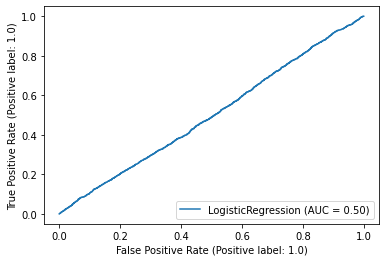

In [15]:
check_train_test(train_df, test_df)

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)



models = []
val_scores = []

for i, (train_index, valid_index) in enumerate(skf.split(train_df, target)):
    

    X_train, X_valid, y_train, y_valid = train_df.loc[train_index], train_df.loc[valid_index], target.loc[train_index], target.loc[valid_index]
    model = RandomForestClassifier(random_state=42)
#     model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    models.append(model)
    
    train_pred = model.predict_proba(X_train)
    train_score = roc_auc_score(y_train, train_pred[:, 1])
    
    pred = model.predict_proba(X_valid)
    val_score = roc_auc_score(y_valid, pred[:, 1])

    val_scores.append(val_score)
    
    print(f"Fold {i}: train score {train_score} val score: {val_score}")
    
print("val score (avg)", np.mean(val_scores))

Fold 0: train score 1.0 val score: 0.8148494983277592
Fold 1: train score 1.0 val score: 0.8276672240802675
Fold 2: train score 1.0 val score: 0.8098851621389184
Fold 3: train score 1.0 val score: 0.8232238916713039
Fold 4: train score 1.0 val score: 0.7800834431269213
val score (avg) 0.8111418438690341


In [82]:
# basic modelling
# from sklearn.model_selection import train_test_split
# target = train["ProdTaken"]
# X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, random_state = 42)
# print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# model = RandomForestClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
# model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
# model.fit(X_train, y_train)
# pred = model.predict_proba(X_valid)
# score = roc_auc_score(y_valid, pred[:, 1])
# print(score)


# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr,tpr,label='LogisticRegression')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

In [17]:
def plot_importance(model, feature_names, topk=10):
    # plot feature importance
    if isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        forest_importances = pd.Series(importances, index=feature_names)
        forest_importances = forest_importances.nlargest(topk)
        fig, ax = plt.subplots(figsize=(8,5))
        forest_importances.plot.bar( ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("importance")
        fig.tight_layout()

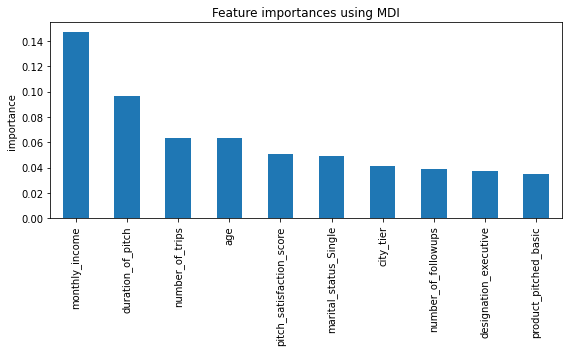

In [18]:
plot_importance(model, train_df.columns)

In [19]:
# submission
predict = np.zeros((len(test_df), 2))
for model in models:
    predict += model.predict_proba(test_df)
predict = predict/5

submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [20]:
submit[1] = predict[:, 1]

In [21]:
submit.to_csv("submission.csv", index=False, header=None)

In [22]:
submit

,0,1
0,3489,0.082
1,3490,0.156
2,3491,0.368
3,3492,0.280
4,3493,0.376
...,...,...
3484,6973,0.254
3485,6974,0.002
3486,6975,0.712
3487,6976,0.122


In [23]:
sum(submit.loc[:, 1]> .5)

176

In [24]:
target.value_counts()

0    2992
1     497
Name: prod_taken, dtype: int64

In [25]:
NUM_COL

['age',
 'city_tier',
 'duration_of_pitch',
 'number_of_person_visiting',
 'number_of_followups',
 'preferred_property_star',
 'number_of_trips',
 'passport',
 'pitch_satisfaction_score',
 'monthly_income']